<a href="https://colab.research.google.com/github/vngeno/E-COMMERCE-RECOMMENDATION-SYSTEM-/blob/develop/Collaborative_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,r2_score,recall_score,confusion_matrix,precision_recall_curve
from collections import Counter
from sklearn.model_selection import StratifiedKFold,KFold,StratifiedShuffleSplit
from nltk import word_tokenize
from nltk.corpus import stopwords
# stop_words = stopwords.words('english')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD,SparsePCA
from sklearn.metrics import classification_report,confusion_matrix
from nltk.tokenize import word_tokenize
from collections import defaultdict
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
import string
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/Team Stars/Data/df_clean.csv",index_col=0)
df.head(2)

,id,name,brand,primarycategories,manufacturernumber,reviews_dorecommend,reviews_numhelpful,reviews_rating,reviews_text,reviews_title,reviews_username
0,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,3,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang
1,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,4,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG


In [ ]:
counts = df['reviews_username'].value_counts()
df_final = df[df['reviews_username'].isin(counts[counts >= 5].index)]
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['reviews_username'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['id'].nunique())

The number of observations in the final data = 4453
Number of unique USERS in the final data =  435
Number of unique PRODUCTS in the final data =  37


In [ ]:
df_final.drop_duplicates()

,id,name,brand,primarycategories,manufacturernumber,reviews_dorecommend,reviews_numhelpful,reviews_rating,reviews_text,reviews_title,reviews_username
1,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,4,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG
6,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,5,ive not had any problame with these batteries ...,... batteries have ordered them in the past be...,ByAmazon Customer
15,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,5,Thankful that I was able to find on Amazon for...,... I was able to find on Amazon for a great p...,ByAmazon Customer
18,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,4,They don't last as long as the brand name but ...,... last as long as the brand name but are goo...,ByAdam
19,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,HL-002619,True,1.0,3,Bought these batteries for my Christmas gifts ...,... my Christmas gifts the month of (december)...,ByAmazon Customer
...,...,...,...,...,...,...,...,...,...,...,...
28285,AVqkIhxunnc1JgDc3kg_,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",Amazon,Electronics,53-004485,False,0.0,1,Worked great but after awhile I wouldn't unloc...,Won't unlock,Aria
28286,AVqkIhxunnc1JgDc3kg_,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",Amazon,Electronics,53-004485,True,0.0,5,The kindle fire hd is a wonderful tool as well...,Wonderful,Doug
28292,AVqkIhxunnc1JgDc3kg_,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",Amazon,Electronics,53-004485,True,0.0,4,Bought for my son and he enjoys playing in it....,Wonderful thus far,Sammie
28312,AVqkIhxunnc1JgDc3kg_,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",Amazon,Electronics,53-004485,True,0.0,4,"the tablet is great, but all the advertising i...","works great, but.....",Jake


In [ ]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot_table(index = 'reviews_username', columns ='id', values = 'reviews_rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (435, 37)
given_num_of_ratings =  2119
possible_num_of_ratings =  16095
density: 13.17%


id,AV-EVZITKZqtpbFMSoqc,AVpe7xlELJeJML43ypLz,AVpfIfGA1cnluZ0-emyp,AVpfl8cLLJeJML43AE3S,AVpflnS7ilAPnD_xehxE,AVpfpK8KLJeJML43BCuD,AVpftoij1cnluZ0-p5n2,AVpfw2hvilAPnD_xh0rH,AVpgNzjwLJeJML43Kpxn,AVpgdkC8ilAPnD_xsvyi,AVph0EeEilAPnD_x9myq,AVphPmHuilAPnD_x3E5h,AVpidLjVilAPnD_xEVpI,AVpjEN4jLJeJML43rpUe,AVqVGWLKnnc1JgDc3jF1,AVqVGWQDv8e3D1O-ldFr,AVqVGZN9QMlgsOJE6eUZ,AVqVGZNvQMlgsOJE6eUY,AVqVGZO3nnc1JgDc3jGK,AVqVGZQBQMlgsOJE6eUb,AVqVGZSEQMlgsOJE6eUc,AVqkIdZiv8e3D1O-leaJ,AVqkIh8WQMlgsOJE6fu-,AVqkIh9HQMlgsOJE6fu_,AVqkIhkhv8e3D1O-lebZ,AVqkIhxunnc1JgDc3kg_,AVqkIiKWnnc1JgDc3khH,AVqkIj9snnc1JgDc3khU,AVwjfXp4QMlgsOJE8qmk,AVwjfXqqQMlgsOJE8qmm,AVzNj1Y0GV-KLJ3aarCo,AVzYlGj3vKc47QAVeZRH,AVzYlGkFvKc47QAVeZRI,AVzYlGnuGV-KLJ3abPUD,AWFFfd9KIwln0LfXiOe0,AWMjN1SSIwln0LfXmWs7,AWP6zKOtIwln0LfXnf2p
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,4.00,0.0,2.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2k4k,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54035723,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATomP,0.0,0.0,0.0,0.0,0.0,0.00,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alan,0.0,0.0,0.0,0.0,0.0,4.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Rank Based Recommendation System**

In [ ]:
#Calculate the average rating for each product 
average_rating = df_final.groupby(['id']).mean().reviews_rating
#Calculate the count of ratings for each product
count_rating = df_final.groupby(['id']).count().reviews_rating

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame(pd.concat([average_rating,count_rating], axis = 1))
final_rating.columns=["Average Rating", "Ratings Count"]

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='Average Rating', ascending=False)

final_rating.head()

,Average Rating,Ratings Count
id,,
AVpfl8cLLJeJML43AE3S,5.0,2
AWMjN1SSIwln0LfXmWs7,5.0,1
AWFFfd9KIwln0LfXiOe0,5.0,3
AVpftoij1cnluZ0-p5n2,5.0,3
AVqVGZNvQMlgsOJE6eUY,5.0,1


# KNN

In [ ]:
# Applying the csr_matrix method to the dataset :
from scipy.sparse import csr_matrix
csr_data = csr_matrix(product_matrix.values)
product_matrix.reset_index(inplace=True)

In [ ]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=15, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=15, p=2,
                 radius=1.0)

In [ ]:
def product_recommendation(product_name):
    n_products_to_reccomend = 4
    product_list = txt[txt['name']==product_name]
    
    if len(product_list):        
        product_idx= product_list.iloc[0]['id']
        product_idx = product_matrix[product_matrix['id'] == product_idx].index
        distances , indices = knn.kneighbors(csr_data[product_idx],n_neighbors=n_products_to_reccomend+1) 
        rec_product_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_product_indices:
            product_idx = product_matrix.iloc[val[0]]['id']
            idx = txt[txt['id'] == product_idx].index
            recommend_frame.append({'name':txt.iloc[idx]['name'].values[0],'Distance':val[1]})
        
        df = pd.DataFrame(recommend_frame,index=range(1,n_products_to_reccomend+1))
        return df
    else:
        return "No product found try another product"


In [ ]:
product_recommendation(txt['name'][2000])


,name,Distance
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",1.000000
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",1.000000
3,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",1.000000
4,AmazonBasics AA Performance Alkaline Batteries...,0.610451


In [ ]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    
    #Finding movies with minimum number of interactions
    recommendations = final_rating[final_rating['Ratings Count'] >= min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='Average Rating', ascending=False)
    
    return recommendations.index[:n]

In [ ]:
#Recommending top 10 products with 5 minimum interactions based on popularity
list(top_n_products(final_rating, 10, 5))

['AVpfIfGA1cnluZ0-emyp',
 'AV-EVZITKZqtpbFMSoqc',
 'AVwjfXp4QMlgsOJE8qmk',
 'AVzNj1Y0GV-KLJ3aarCo',
 'AVphPmHuilAPnD_x3E5h',
 'AVwjfXqqQMlgsOJE8qmm',
 'AVzYlGnuGV-KLJ3abPUD',
 'AVzYlGkFvKc47QAVeZRI',
 'AVpfpK8KLJeJML43BCuD',
 'AVqVGWLKnnc1JgDc3jF1']

## Memory Recommenders

**Collaborative Filtering based Recommendation System**

In [ ]:
final_ratings_matrix.head()

id,AV-EVZITKZqtpbFMSoqc,AVpe7xlELJeJML43ypLz,AVpfIfGA1cnluZ0-emyp,AVpfl8cLLJeJML43AE3S,AVpflnS7ilAPnD_xehxE,AVpfpK8KLJeJML43BCuD,AVpftoij1cnluZ0-p5n2,AVpfw2hvilAPnD_xh0rH,AVpgNzjwLJeJML43Kpxn,AVpgdkC8ilAPnD_xsvyi,AVph0EeEilAPnD_x9myq,AVphPmHuilAPnD_x3E5h,AVpidLjVilAPnD_xEVpI,AVpjEN4jLJeJML43rpUe,AVqVGWLKnnc1JgDc3jF1,AVqVGWQDv8e3D1O-ldFr,AVqVGZN9QMlgsOJE6eUZ,AVqVGZNvQMlgsOJE6eUY,AVqVGZO3nnc1JgDc3jGK,AVqVGZQBQMlgsOJE6eUb,AVqVGZSEQMlgsOJE6eUc,AVqkIdZiv8e3D1O-leaJ,AVqkIh8WQMlgsOJE6fu-,AVqkIh9HQMlgsOJE6fu_,AVqkIhkhv8e3D1O-lebZ,AVqkIhxunnc1JgDc3kg_,AVqkIiKWnnc1JgDc3khH,AVqkIj9snnc1JgDc3khU,AVwjfXp4QMlgsOJE8qmk,AVwjfXqqQMlgsOJE8qmm,AVzNj1Y0GV-KLJ3aarCo,AVzYlGj3vKc47QAVeZRH,AVzYlGkFvKc47QAVeZRI,AVzYlGnuGV-KLJ3abPUD,AWFFfd9KIwln0LfXiOe0,AWMjN1SSIwln0LfXmWs7,AWP6zKOtIwln0LfXnf2p
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,4.00,0.0,2.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2k4k,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54035723,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATomP,0.0,0.0,0.0,0.0,0.0,0.00,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alan,0.0,0.0,0.0,0.0,0.0,4.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

id,AV-EVZITKZqtpbFMSoqc,AVpe7xlELJeJML43ypLz,AVpfIfGA1cnluZ0-emyp,AVpfl8cLLJeJML43AE3S,AVpflnS7ilAPnD_xehxE,AVpfpK8KLJeJML43BCuD,AVpftoij1cnluZ0-p5n2,AVpfw2hvilAPnD_xh0rH,AVpgNzjwLJeJML43Kpxn,AVpgdkC8ilAPnD_xsvyi,AVph0EeEilAPnD_x9myq,AVphPmHuilAPnD_x3E5h,AVpidLjVilAPnD_xEVpI,AVpjEN4jLJeJML43rpUe,AVqVGWLKnnc1JgDc3jF1,AVqVGWQDv8e3D1O-ldFr,AVqVGZN9QMlgsOJE6eUZ,AVqVGZNvQMlgsOJE6eUY,AVqVGZO3nnc1JgDc3jGK,AVqVGZQBQMlgsOJE6eUb,AVqVGZSEQMlgsOJE6eUc,AVqkIdZiv8e3D1O-leaJ,AVqkIh8WQMlgsOJE6fu-,AVqkIh9HQMlgsOJE6fu_,AVqkIhkhv8e3D1O-lebZ,AVqkIhxunnc1JgDc3kg_,AVqkIiKWnnc1JgDc3khH,AVqkIj9snnc1JgDc3khU,AVwjfXp4QMlgsOJE8qmk,AVwjfXqqQMlgsOJE8qmm,AVzNj1Y0GV-KLJ3aarCo,AVzYlGj3vKc47QAVeZRH,AVzYlGkFvKc47QAVeZRI,AVzYlGnuGV-KLJ3abPUD,AWFFfd9KIwln0LfXiOe0,AWMjN1SSIwln0LfXmWs7,AWP6zKOtIwln0LfXnf2p
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,4.00,0.0,2.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,4.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error# defining a function to get similar users

def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]):
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user, sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [Tuple[0] for Tuple in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [Tuple[1] for Tuple in similarity]   ##Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

In [ ]:
similar = similar_users(3, final_ratings_matrix)[0][0:10]
similar

[19, 23, 127, 131, 189, 235, 260, 276, 298, 374]

In [ ]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]]),
 array([[1.]])]

In [ ]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]):
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user, sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [Tuple[0] for Tuple in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [Tuple[1] for Tuple in similarity]   ##Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

In [ ]:
similar = similar_users(3, final_ratings_matrix)[0][0:10]
similar

[19, 23, 127, 131, 189, 235, 260, 276, 298, 374]

In [ ]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):
    
    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

In [ ]:
recommendations(3, 5, final_ratings_matrix)

['AVpfpK8KLJeJML43BCuD',
 'AVqkIdZiv8e3D1O-leaJ',
 'AVpjEN4jLJeJML43rpUe',
 'AVqkIhxunnc1JgDc3kg_',
 'AVzNj1Y0GV-KLJ3aarCo']

## Singular Value Decomposition

In [ ]:
from scipy.sparse.linalg import svds # for sparse matrices

# Singular Value Decomposition
U, s, Vt = svds(final_ratings_matrix, k = 5) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [ ]:
U.shape #checking the shape of the U matrix

(435, 5)

In [ ]:
sigma.shape #checking the shape of the sigma matrix

(5, 5)

In [ ]:
Vt.shape #checking the shape of the Vt matrix

(5, 37)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()

id,AV-EVZITKZqtpbFMSoqc,AVpe7xlELJeJML43ypLz,AVpfIfGA1cnluZ0-emyp,AVpfl8cLLJeJML43AE3S,AVpflnS7ilAPnD_xehxE,AVpfpK8KLJeJML43BCuD,AVpftoij1cnluZ0-p5n2,AVpfw2hvilAPnD_xh0rH,AVpgNzjwLJeJML43Kpxn,AVpgdkC8ilAPnD_xsvyi,AVph0EeEilAPnD_x9myq,AVphPmHuilAPnD_x3E5h,AVpidLjVilAPnD_xEVpI,AVpjEN4jLJeJML43rpUe,AVqVGWLKnnc1JgDc3jF1,AVqVGWQDv8e3D1O-ldFr,AVqVGZN9QMlgsOJE6eUZ,AVqVGZNvQMlgsOJE6eUY,AVqVGZO3nnc1JgDc3jGK,AVqVGZQBQMlgsOJE6eUb,AVqVGZSEQMlgsOJE6eUc,AVqkIdZiv8e3D1O-leaJ,AVqkIh8WQMlgsOJE6fu-,AVqkIh9HQMlgsOJE6fu_,AVqkIhkhv8e3D1O-lebZ,AVqkIhxunnc1JgDc3kg_,AVqkIiKWnnc1JgDc3khH,AVqkIj9snnc1JgDc3khU,AVwjfXp4QMlgsOJE8qmk,AVwjfXqqQMlgsOJE8qmm,AVzNj1Y0GV-KLJ3aarCo,AVzYlGj3vKc47QAVeZRH,AVzYlGkFvKc47QAVeZRI,AVzYlGnuGV-KLJ3abPUD,AWFFfd9KIwln0LfXiOe0,AWMjN1SSIwln0LfXmWs7,AWP6zKOtIwln0LfXnf2p
0,0.055686,4.708025e-16,0.043572,0.036819,0.012707,0.710616,0.017816,2.811064,9.315522e-16,5.187813,2.832493,0.627927,0.248505,5.132905,2.467826,0.958991,0.117433,0.000982,0.108786,0.126949,0.356393,4.636602,0.016886,0.098708,0.152662,1.090407,0.045836,0.016886,0.225456,0.434669,0.047364,0.087702,0.861473,0.134197,0.036819,0.004479,0.066814
1,0.004314,4.929996e-15,0.015048,0.015828,0.047769,0.586752,0.028802,0.007145,3.718568e-15,0.128692,0.007781,0.557807,0.358627,0.026991,0.207267,4.615332,0.156705,0.002821,0.009195,0.139763,0.462074,0.166220,5.294179,4.774144,0.317558,4.339531,4.257122,5.294179,0.868114,0.859826,0.574887,0.312382,1.558528,0.427584,0.015828,0.009876,0.007015
2,0.006224,2.761735e-15,0.075236,0.013397,0.001877,0.320011,0.010537,5.017665,1.789560e-15,0.015080,5.022585,0.148466,0.018287,0.020433,4.899624,0.113355,0.023775,0.022682,0.068023,0.059843,0.097933,0.054322,0.037161,0.022856,0.061644,0.094946,0.053135,0.037161,0.148715,0.095766,0.203911,0.048353,0.170716,0.002766,0.013397,0.012909,0.002074
3,0.004979,2.209388e-15,0.060189,0.010717,0.001501,0.256009,0.008430,4.014132,1.431648e-15,0.012064,4.018068,0.118773,0.014630,0.016346,3.919699,0.090684,0.019020,0.018146,0.054419,0.047875,0.078346,0.043458,0.029728,0.018285,0.049315,0.075957,0.042508,0.029728,0.118972,0.076613,0.163129,0.038682,0.136573,0.002212,0.010717,0.010327,0.001659
4,0.012825,1.906202e-16,0.019237,0.003725,0.001616,0.139569,0.011170,0.168922,2.218615e-16,0.170854,0.138798,0.128713,0.018784,0.169130,0.094223,0.612261,0.032460,0.001701,0.027279,0.031083,0.063940,0.127553,0.049792,0.046614,0.039458,0.608376,0.054950,0.049792,0.071554,0.098783,0.034906,0.017137,0.184992,0.022935,0.003725,0.002511,0.011488


In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(user_index, interactions_matrix, preds_df, num_recommendations):
    
    # Get and sort the user's ratings from the actual and predicted interaction matrix
    sorted_user_ratings = interactions_matrix.loc[user_index].sort_values(ascending=False)
    sorted_user_predictions = preds_df.loc[user_index].sort_values(ascending=False)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Products'
    temp.columns = ['user_ratings', 'user_predictions']
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp['user_ratings'] == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values(by='user_predictions', ascending=False) #Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))

In [ ]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(121, final_ratings_matrix, preds_df, 5)


Below are the recommended products for user(user_id = 121):

Recommended Products
AVzYlGkFvKc47QAVeZRI    1.217662
AVpfpK8KLJeJML43BCuD    1.027543
AVphPmHuilAPnD_x3E5h    0.831582
AVwjfXp4QMlgsOJE8qmk    0.579113
AVqVGZSEQMlgsOJE6eUc    0.436662
Name: user_predictions, dtype: float64


In [ ]:
# Actual ratings given by the users
final_ratings_matrix.head()

id,AV-EVZITKZqtpbFMSoqc,AVpe7xlELJeJML43ypLz,AVpfIfGA1cnluZ0-emyp,AVpfl8cLLJeJML43AE3S,AVpflnS7ilAPnD_xehxE,AVpfpK8KLJeJML43BCuD,AVpftoij1cnluZ0-p5n2,AVpfw2hvilAPnD_xh0rH,AVpgNzjwLJeJML43Kpxn,AVpgdkC8ilAPnD_xsvyi,AVph0EeEilAPnD_x9myq,AVphPmHuilAPnD_x3E5h,AVpidLjVilAPnD_xEVpI,AVpjEN4jLJeJML43rpUe,AVqVGWLKnnc1JgDc3jF1,AVqVGWQDv8e3D1O-ldFr,AVqVGZN9QMlgsOJE6eUZ,AVqVGZNvQMlgsOJE6eUY,AVqVGZO3nnc1JgDc3jGK,AVqVGZQBQMlgsOJE6eUb,AVqVGZSEQMlgsOJE6eUc,AVqkIdZiv8e3D1O-leaJ,AVqkIh8WQMlgsOJE6fu-,AVqkIh9HQMlgsOJE6fu_,AVqkIhkhv8e3D1O-lebZ,AVqkIhxunnc1JgDc3kg_,AVqkIiKWnnc1JgDc3khH,AVqkIj9snnc1JgDc3khU,AVwjfXp4QMlgsOJE8qmk,AVwjfXqqQMlgsOJE8qmm,AVzNj1Y0GV-KLJ3aarCo,AVzYlGj3vKc47QAVeZRH,AVzYlGkFvKc47QAVeZRI,AVzYlGnuGV-KLJ3abPUD,AWFFfd9KIwln0LfXiOe0,AWMjN1SSIwln0LfXmWs7,AWP6zKOtIwln0LfXnf2p
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,4.00,0.0,2.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,4.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Find average actual rating for each item
final_ratings_matrix.mean()

id
AV-EVZITKZqtpbFMSoqc    0.055172
AVpe7xlELJeJML43ypLz    0.776336
AVpfIfGA1cnluZ0-emyp    0.066667
AVpfl8cLLJeJML43AE3S    0.011494
AVpflnS7ilAPnD_xehxE    0.004598
AVpfpK8KLJeJML43BCuD    0.594215
AVpftoij1cnluZ0-p5n2    0.022989
AVpfw2hvilAPnD_xh0rH    2.560432
AVpgNzjwLJeJML43Kpxn    0.780259
AVpgdkC8ilAPnD_xsvyi    1.545479
AVph0EeEilAPnD_x9myq    2.461111
AVphPmHuilAPnD_x3E5h    0.501533
AVpidLjVilAPnD_xEVpI    0.131034
AVpjEN4jLJeJML43rpUe    1.531686
AVqVGWLKnnc1JgDc3jF1    2.260536
AVqVGWQDv8e3D1O-ldFr    1.814331
AVqVGZN9QMlgsOJE6eUZ    0.103448
AVqVGZNvQMlgsOJE6eUY    0.011494
AVqVGZO3nnc1JgDc3jGK    0.091954
AVqVGZQBQMlgsOJE6eUb    0.114943
AVqVGZSEQMlgsOJE6eUc    0.282375
AVqkIdZiv8e3D1O-leaJ    1.299808
AVqkIh8WQMlgsOJE6fu-    0.395402
AVqkIh9HQMlgsOJE6fu_    0.351724
AVqkIhkhv8e3D1O-lebZ    0.119540
AVqkIhxunnc1JgDc3kg_    1.798892
AVqkIiKWnnc1JgDc3khH    0.301149
AVqkIj9snnc1JgDc3khU    0.395402
AVwjfXp4QMlgsOJE8qmk    0.319540
AVwjfXqqQMlgsOJE8qmm    0.385057
AVzNj1Y

In [ ]:
#create a dataframe containing average actual ratings and avearge predicted ratings for each product
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
id,,
AV-EVZITKZqtpbFMSoqc,0.055172,0.043597
AVpe7xlELJeJML43ypLz,0.776336,0.782822
AVpfIfGA1cnluZ0-emyp,0.066667,0.080314
AVpfl8cLLJeJML43AE3S,0.011494,0.020123
AVpflnS7ilAPnD_xehxE,0.004598,0.009597


In [ ]:
#Calculate and print RMSE using the mean_square_error function
RMSE = mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.03380476263314376 



In [ ]:
# Enter 'user_index' and 'num_recommendations' for the user #
recommend_items(100, final_ratings_matrix, preds_df, 10)


Below are the recommended products for user(user_id = 100):

Recommended Products
AVpfw2hvilAPnD_xh0rH    1.827632e-15
AVqVGWQDv8e3D1O-ldFr    1.749424e-15
AVqkIhxunnc1JgDc3kg_    1.621330e-15
AVzYlGkFvKc47QAVeZRI    1.310590e-15
AVqkIh9HQMlgsOJE6fu_    1.167038e-15
AVqkIj9snnc1JgDc3khU    1.128812e-15
AVph0EeEilAPnD_x9myq    1.060497e-15
AVqVGWLKnnc1JgDc3jF1    9.880950e-16
AVqkIh8WQMlgsOJE6fu-    9.581153e-16
AVqkIiKWnnc1JgDc3khH    7.963117e-16
Name: user_predictions, dtype: float64


# **keras**

In [ ]:
#Getting the data
dataset=df[['id','reviews_username','reviews_rating']]
dataset=dataset.rename(columns={'id':'product_id','reviews_username':'user_id','reviews_rating':'rating','reviews_username':'user_id'})
dataset.head()

,product_id,user_id,rating
0,21,8417,3
1,21,5201,4
2,21,6994,5
3,21,8769,5
4,21,8713,5


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
n_users = len(dataset.user_id.unique())
n_products = len(dataset.product_id.unique())

### Modelling

In [ ]:
#creating embedding model
#Input: Input for both users and ratings
#Embedding Layers: Embeddings for user and users
#Dot: combines embeddings using a dot product
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

product_input = Input(shape=[1], name="Product-Input")
product_embedding = Embedding(n_products+1, 5, name="Product-Embedding")(product_input)
product_vec = Flatten(name="Flatten-Books")(product_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)


prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])
prod1 = Dense(128, activation='relu')(prod)
model = Model([user_input, product_input], prod1)
model.compile('adam', 'mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Product-Input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Product-Embedding (Embedding)   (None, 1, 5)         330         Product-Input[0][0]              
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         81350       User-Input[0][0]                 
______________________________________________________________________________________________

In [ ]:
#training the model
history = model.fit([train.user_id, train.product_id], train.rating,
                    epochs=10,
                    batch_size=32, 
                    verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/10
638/638 [==============================] - 2s 2ms/step - loss: 18.4413 - val_loss: 15.6403
Epoch 2/10
638/638 [==============================] - 1s 2ms/step - loss: 12.6371 - val_loss: 10.4975
Epoch 3/10
638/638 [==============================] - 1s 2ms/step - loss: 6.1514 - val_loss: 6.1724
Epoch 4/10
638/638 [==============================] - 1s 2ms/step - loss: 1.9548 - val_loss: 4.5957
Epoch 5/10
638/638 [==============================] - 1s 2ms/step - loss: 0.6811 - val_loss: 4.1240
Epoch 6/10
638/638 [==============================] - 1s 2ms/step - loss: 0.3207 - val_loss: 3.9308
Epoch 7/10
638/638 [==============================] - 1s 2ms/step - loss: 0.2161 - val_loss: 3.8323
Epoch 8/10
638/638 [==============================] - 1s 2ms/step - loss: 0.1788 - val_loss: 3.7644
Epoch 9/10
638/638 [==============================] - 1s 2ms/step - loss: 0.1651 - val_loss: 3.7065
Epoch 10/10
638/638 [==============================] - 1s 2ms/step - loss: 0.1651 - val_loss: 3.

### Visualizing embeddings

In [ ]:
# Extract embeddings
product_em = model.get_layer('Product-Embedding')
product_em_weights = product_em.get_weights()[0]

**PCA**

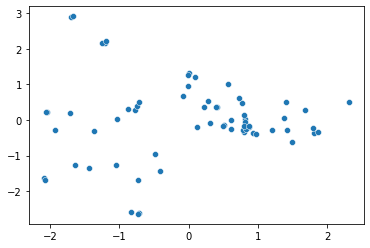

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
#transforming the embedding to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(product_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

**TSNE**

[t-SNE] Computing 65 nearest neighbors...
[t-SNE] Indexed 66 samples in 0.000s...
[t-SNE] Computed neighbors for 66 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 66 / 66
[t-SNE] Mean sigma: 1.644768
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.001167
[t-SNE] KL divergence after 300 iterations: 0.748494


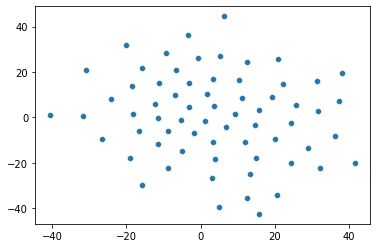

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(product_em_weights)
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

### Making Recommendations

In [ ]:
# Creating dataset for making recommendations for the first user
product_data = np.array(list(set(dataset.product_id)))
user = np.array([1 for i in range(len(product_data))])
predictions = model.predict([user, product_data])
predictions = np.array([a[0] for a in predictions])
recommended_product_ids = (-predictions).argsort()[:5]
print(recommended_product_ids)
print(predictions[recommended_product_ids])

[44 34 43 49 51]
[5.1917458 5.1842537 4.686127  4.5803423 4.5797644]
